In [1]:
import datetime
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Data Preprocessing

In [2]:
def preprocessing(file):
    #* 讀取資料
    stock_data = pd.read_excel(file)
    stock_data = stock_data.drop(columns=['證券代碼'])
    #? print(stock_data)

    #* 擷取股票年月與簡稱
    stock_year = stock_data['年月'].unique()
    stock_name = stock_data['簡稱'].unique()
    #? print(stock_year)
    #? print(stock_name)

    #* 移除第2009年
    stock = stock_data[stock_data['年月'].isin(stock_year[:-1])]
    #? print(stock)
    
    return stock_data

## Normalization

In [3]:
def normalization(data):
    for col in data.columns[2:-2]:
        data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
        
    return data

## Split train and test by TV(1997~2008)

In [4]:
def split_train_test(stock, TV):
    #* 擷取股票年月與
    stock_year = stock['年月'].unique()
    
    basic_train_data = stock[stock['年月'].isin(stock_year[:TV])]
    train_label = basic_train_data['ReturnMean_year_Label']
    #* '收盤價(元)_年': 市價無法反映基本面 、 '市值(百萬元)' = 股數 * 股價
    train_data = basic_train_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])

    basic_test_data = stock[stock['年月'].isin(stock_year[TV:])]
    test_label = basic_test_data['ReturnMean_year_Label']
    #* '收盤價(元)_年': 市價無法反映基本面 、 '市值(百萬元)' = 股數 * 股價
    test_data = basic_test_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])
    
    return train_data, train_label, test_data, test_label

## Genetic Algorithm

### 染色體解碼

In [5]:
def decode(chromosome):
    dna_len = len(chromosome)
    code = 0
    for i in range(dna_len):
        gene = dna_len - i - 1
        code += chromosome[gene] * (2**i)
    
    return code

### 初始種群

In [6]:
def initial_population(pop_num, dna_length):
    population = []
    for i in range(pop_num):
        chromosome = np.ones(dna_length, np.bool8)     
        chromosome[:int(0.3 * dna_length)] = False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    # print(population)
    return population

### 適應度

In [7]:
def fitness(data, pop):
    train_data, train_label, test_data, test_label = data
    
    scores = []
    model = RandomForestClassifier()
    for chromosome in pop:
        model.fit(train_data.values[:, chromosome], train_label) 
        predictions = model.predict(test_data.values[:, chromosome])
        test_score = metrics.accuracy_score(test_label, predictions)
        scores.append(test_score) # 準確率
        
    scores, pop = np.array(scores), np.array(pop) 
    inds = np.argsort(scores)
    return list(pop[inds, :][::-1]), list(scores[inds][::-1])  # my_list[start(開始的index):end(結束的index):sep(間隔)]

### 選擇

In [8]:
def selection(data, pop):
    ran_F = random.choices(pop, k=2)
    ran_M = random.choices(pop, k=2)
    
    ran_F, sort_F = fitness(data, ran_F)
    ran_M, sort_M = fitness(data, ran_M)

    father = ran_F[0]
    mother = ran_M[0]

    return father, mother

### 交配

In [9]:
def cross(data, pop, cross_rate=0.7):
    pop_size, dna_len = np.array(pop).shape
    new_pop = []
    while len(new_pop) != pop_size:
        father, mother = selection(data, pop)

        if np.random.rand() < cross_rate:
            cross_point = np.random.randint(low=0, high=dna_len)
            cut_F = father[cross_point:].copy()
            cut_M = mother[cross_point:].copy()
            father[cross_point:] = cut_M
            mother[cross_point:] = cut_F
            
        new_pop.extend([father, mother])
        
    return new_pop

### 變異

In [10]:
def mutation(cross_pop, mutation_rate=0.005):
    pop_size, dna_len = np.array(cross_pop).shape
    new_pop = []
    for i in range(pop_size):
        if np.random.rand() < mutation_rate:
            mutation_point = np.random.randint(low=0, high=dna_len)
            if cross_pop[i][mutation_point] == 0:
                cross_pop[i][mutation_point] = 1
            else:
                cross_pop[i][mutation_point] = 0
                
        new_pop.append(cross_pop[i])

    return new_pop

### 分析

#### 計算種群適應度最佳值及平均值

In [11]:
def best_avg_fitness(score):
    return np.round(np.max(score), 10), np.round(np.mean(score), 10)

#### 繪製種群狀態

In [12]:
def draw_fitness(run, best_pop, avg_pop):
    plt.title("Best & Avg fitness") # 圖表標題
    plt.xlabel("Generation") # 圖表x軸標題
    plt.ylabel("fitness") # 圖表y軸標題
    plt.plot(run, best_pop, color='r', label='Best fitness', linestyle='-', marker='*') # 定義畫圖的顏色、圖例、線條、形狀、寬度
    plt.plot(run, avg_pop, color='b', label='Avg fitness', linestyle='--', marker='o') # 定義畫圖的顏色、圖例、線條、形狀、寬度
    plt.grid(axis='y') # 定義網格
    plt.legend(loc='lower right') # 當有兩種以上資料，可以使用.legend()來顯示資料的圖例
    plt.savefig('Random_Forest.png')

#### 策略

In [13]:
strategy_money = []
start_money = 10000  # 初始金額

def strategy(predict_data, TV):
    df = pd.read_excel('./top200_training.xls')
    stocks_data = df.drop(['年月', 'Return', 'ReturnMean_year_Label'], axis=1)
    stocks_name = df['簡稱'].unique()
    current_stock = dict()
    for n in stocks_name:
        current_stock[n] = 0
    current_money = start_money

    # 策略
    for pre_times in range(12 - TV):
        tmp = 0
        tmp_stock = []
        for i in range(200):
            # 賣出
            if predict_data[pre_times * 200 + i] == -1:
                predict_name = stocks_data["簡稱"][(TV + pre_times) * 200 + i]
                current_money += stocks_data["收盤價(元)_年"][(TV + pre_times) * 200 + i] * current_stock[predict_name]
                current_stock[predict_name] = 0

            # 紀錄要買哪隻和每隻要分多少錢下去
            if predict_data[pre_times * 200 + i] == 1:
                tmp += 1
                tmp_stock.append(i)

        if tmp:
            per_money = current_money / tmp
            for j in tmp_stock:
                # 買入
                if stocks_data["收盤價(元)_年"][(TV + pre_times) * 200 + j] != 0:
                    predict_name = stocks_data["簡稱"][(TV + pre_times) * 200 + j]
                    current_stock[predict_name] += per_money / stocks_data["收盤價(元)_年"][(TV + pre_times) * 200 + j]

            current_money = 0

    # 折現
    for i in range(2400, 2600):
        stocks_name = stocks_data["簡稱"][i]
        current_money += current_stock[stocks_name] * stocks_data["收盤價(元)_年"][i]
        
    #* 最後一年無法折現的股票以均價計算其價值
    current_money += sum(current_stock.values()) * np.mean(stocks_data["收盤價(元)_年"])

    strategy_money.append(math.floor(current_money))

#### 計算IRR

In [14]:
def ROI():
    ROI = []
    for i in range(len(strategy_money)):
        ROI.append((strategy_money[i] - start_money) / start_money)
    return ROI

def IRR():
    IRR = []
    roi = ROI()
    for i in range(len(roi)):
        IRR.append(((roi[i] + 1) ** (1 / (11 - i)) - 1) * 100)
        
    print("IRR:", IRR)

    plt.plot(IRR)
    plt.xlabel("Train_time(year)")
    plt.ylabel("Strategy IRR(%)")
    plt.show()

## Main Function

[TV1]
Best_Chromosome: [0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0]
測試結果:
[ 1  1  1 ... -1 -1 -1]
score: 0.58125
strategy_money:  63314
[TV2]
Best_Chromosome: [0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1]
測試結果:
[-1  1  1 ... -1 -1 -1]
score: 0.5736363636363636
strategy_money:  35024
[TV3]
Best_Chromosome: [0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1]
測試結果:
[ 1  1  1 ... -1 -1 -1]
score: 0.583
strategy_money:  104319
[TV4]
Best_Chromosome: [0 1 0 1 0 0 0 0 1 1 0 0 1 1 0 1]
測試結果:
[-1 -1 -1 ... -1 -1 -1]
score: 0.5977777777777777
strategy_money:  69070
[TV5]
Best_Chromosome: [1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1]
測試結果:
[-1 -1 -1 ... -1 -1 -1]
score: 0.63125
strategy_money:  96681
[TV6]
Best_Chromosome: [1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1]
測試結果:
[ 1 -1 -1 ... -1 -1 -1]
score: 0.6307142857142857
strategy_money:  66945
[TV7]
Best_Chromosome: [1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1]
測試結果:
[-1 -1  1 ... -1 -1 -1]
score: 0.63
strategy_money:  61218
[TV8]
Best_Chromosome: [0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0]
測試結果:
[-1 -1  1 -1 -1 -1 -1 -1  1 -1  1

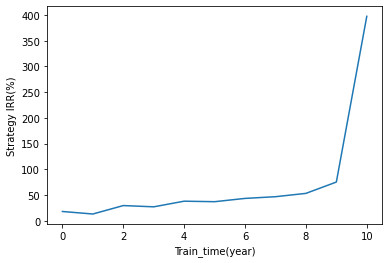

In [15]:
if __name__=="__main__":
    for TV in range(1, 12):
        file_path = './top200_training.xls'
        stock = preprocessing(file_path)
        normalized_stock = normalization(stock)
        train_data, train_label, test_data, test_label = split_train_test(normalized_stock, TV)
        data = [train_data, train_label, test_data, test_label]
        
        #* 設定GA參數
        POP_SIZE = 80 # 種群大小
        DNA_LEN = 16 # 染色體長度: 16個特徵
        
        cross_rate = 0.7 # 交配機率
        mutation_rate = 0.001 # 變異機率
        
        #* 初始種群
        pop = initial_population(POP_SIZE, DNA_LEN)

        #* 迭代次數
        generation_num = 30
        
        #* early stopping
        overfit_num = 0
        
        i = 0
        best_fitness_list = []
        avg_fitness_list = []
        run = []
        while overfit_num < 3 and i < generation_num: # best fitness & average fitness 連續相等3次則中斷
            # print(f"[Generation {i + 1}]")
            cross_pop = cross(data, pop, cross_rate) # 選擇 -> 交配
            mutation_pop = mutation(cross_pop, mutation_rate) # 變異
            pop = mutation_pop
            i += 1
            
            pop, score = fitness(data, pop)
            # print(f"Best chromosome: {pop[0]}")
            best_fitness, average_fitness = best_avg_fitness(score)
            # print(f"Best fitness: {best_fitness}")
            # print(f"Avg fitness: {average_fitness}\n")
            best_fitness_list.append(best_fitness)
            avg_fitness_list.append(average_fitness)
            run.append(i + 1)
            
            #* early stopping
            if best_fitness == average_fitness:
                overfit_num += 1
            else:
                overfit_num = 0
            
        print(f"[TV{TV}]")
        best_chromosome = pop[0]
        print(f"Best_Chromosome: {best_chromosome.astype('int8')}")
        
        #! test result
        print(f"測試結果:")
        test_model = RandomForestClassifier()
        test_model.fit(train_data.values[:, best_chromosome], train_label)
        
        #* predict label
        predictions = test_model.predict(test_data.values[:, best_chromosome])
        print(predictions)
        
        #* test accuracy
        test_score = metrics.accuracy_score(test_label, predictions)
        print(f"score: {test_score}")
        
        strategy(predictions, TV)
        print('strategy_money: ', strategy_money[TV - 1])
        
        #! fitness picture
        # draw_fitness(run, best_fitness_list, avg_fitness_list)
        
    IRR()